# embedding module

In [1]:
import torch
from torch import nn

In [3]:
# an Embedding module containing 10 tensors of size 3
embedding = nn.Embedding(10, 3)

In [4]:
# a batch of 2 samples of 4 indices each
input = torch.LongTensor([[1,2,4,5],[4,3,2,9]])

In [5]:
embedding(input)

tensor([[[-0.5492, -1.1496,  1.2080],
         [-0.6645,  0.8390, -0.8144],
         [ 0.5169,  0.4132, -0.0543],
         [ 1.6722, -1.2496, -0.3160]],

        [[ 0.5169,  0.4132, -0.0543],
         [ 0.8651, -0.0635,  0.6112],
         [-0.6645,  0.8390, -0.8144],
         [ 0.1893,  1.1009,  1.4389]]])

In [6]:
# example with padding_idx
embedding = nn.Embedding(10, 3, padding_idx=0)
input = torch.LongTensor([[0,2,0,5]])
embedding(input)

tensor([[[ 0.0000,  0.0000,  0.0000],
         [-0.8590,  1.3562,  0.0523],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.6379,  0.9526,  0.0189]]])

# ngram LM

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [9]:
word_to_ix = {"hello": 0, "world": 1}
embeds = nn.Embedding(2, 5)  # 2 words in vocab, 5 dimensional embeddings
lookup_tensor = torch.tensor([word_to_ix["hello"]], dtype=torch.long)
hello_embed = embeds(lookup_tensor)
print(hello_embed)

tensor([[ 0.6614,  0.2669,  0.0617,  0.6213, -0.4519]])


In [10]:
CONTEXT_SIZE = 2
EMBEDDING_DIM = 10
# We will use Shakespeare Sonnet 2
test_sentence = """When forty winters shall besiege thy brow,
And dig deep trenches in thy beauty's field,
Thy youth's proud livery so gazed on now,
Will be a totter'd weed of small worth held:
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say, within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise.
How much more praise deserv'd thy beauty's use,
If thou couldst answer 'This fair child of mine
Shall sum my count, and make my old excuse,'
Proving his beauty by succession thine!
This were to be new made when thou art old,
And see thy blood warm when thou feel'st it cold.""".split()
# we should tokenize the input, but we will ignore that for now
# build a list of tuples.  Each tuple is ([ word_i-2, word_i-1 ], target word)
trigrams = [([test_sentence[i], test_sentence[i + 1]], test_sentence[i + 2])
            for i in range(len(test_sentence) - 2)]
# print the first 3, just so you can see what they look like
print(trigrams[:3])

vocab = set(test_sentence)
word_to_ix = {word: i for i, word in enumerate(vocab)}


class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs


losses = []
loss_function = nn.NLLLoss()
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.001)

for epoch in range(10):
    total_loss = 0
    for context, target in trigrams:

        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old
        # instance
        model.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        log_probs = model(context_idxs)

        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a tensor)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()
    losses.append(total_loss)
print(losses)  # The loss decreased every iteration over the training data!

[(['When', 'forty'], 'winters'), (['forty', 'winters'], 'shall'), (['winters', 'shall'], 'besiege')]
[520.4697849750519, 517.9997153282166, 515.5484156608582, 513.1148540973663, 510.69636726379395, 508.29099345207214, 505.8987572193146, 503.520117521286, 501.15412640571594, 498.79959201812744]


# CBOW

In [20]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
 
torch.manual_seed(1)
 
CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right
raw_text = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells.""".split()
 
vocab = set(raw_text)
vocab_size = len(vocab)
 
word_to_ix = {word: i for i, word in enumerate(vocab)}
data = []
for i in range(2, len(raw_text) - 2):
    context = [raw_text[i - 2], raw_text[i - 1],
               raw_text[i + 1], raw_text[i + 2]]
    target = raw_text[i]
    data.append((context, target))
print(data[:5])
 

class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW,self).__init__() 
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, vocab_size)
 
 
    def forward(self, inputs):
        embeds = self.embeddings(inputs)
        add_embeds = torch.sum(embeds, dim=0).view(1,-1)
        out = self.linear1(add_embeds)
        log_probs = F.log_softmax(out)
        return log_probs 

def make_context_vector(context, word_to_ix):
    idxs = [word_to_ix[w] for w in context]
    tensor = torch.LongTensor(idxs)
    return Variable(tensor)
 

# make_context_vector(data[0][0], word_to_ix)
 
losses = []
loss_function = nn.NLLLoss()
model = CBOW(vocab_size, embedding_dim=20)
optimizer = optim.SGD(model.parameters(), lr=0.001)
 
for epoch in range(100):
    total_loss = torch.FloatTensor([0])
    for context, target in data:
        context_idxs = [word_to_ix[w] for w in context]
        target_idx = word_to_ix[target]
        context_var = Variable(torch.LongTensor(context_idxs))
        target_var = Variable(torch.LongTensor([target_idx]))
        model.zero_grad()
        log_probs = model(context_var)
 
        loss = loss_function(log_probs, target_var)
        loss.backward()
        optimizer.step()
 
        total_loss += loss.data
    losses.append(total_loss)
print(losses)

[(['We', 'are', 'to', 'study'], 'about'), (['are', 'about', 'study', 'the'], 'to'), (['about', 'to', 'the', 'idea'], 'study'), (['to', 'study', 'idea', 'of'], 'the'), (['study', 'the', 'of', 'a'], 'idea')]


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[tensor([ 245.5927]), tensor([ 240.6575]), tensor([ 235.8352]), tensor([ 231.1232]), tensor([ 226.5193]), tensor([ 222.0219]), tensor([ 217.6293]), tensor([ 213.3403]), tensor([ 209.1534]), tensor([ 205.0673]), tensor([ 201.0808]), tensor([ 197.1924]), tensor([ 193.4006]), tensor([ 189.7036]), tensor([ 186.0997]), tensor([ 182.5868]), tensor([ 179.1627]), tensor([ 175.8253]), tensor([ 172.5721]), tensor([ 169.4005]), tensor([ 166.3081]), tensor([ 163.2923]), tensor([ 160.3506]), tensor([ 157.4805]), tensor([ 154.6795]), tensor([ 151.9454]), tensor([ 149.2757]), tensor([ 146.6684]), tensor([ 144.1213]), tensor([ 141.6325]), tensor([ 139.2001]), tensor([ 136.8223]), tensor([ 134.4973]), tensor([ 132.2236]), tensor([ 129.9996]), tensor([ 127.8238]), tensor([ 125.6947]), tensor([ 123.6111]), tensor([ 121.5715]), tensor([ 119.5749]), tensor([ 117.6199]), tensor([ 115.7055]), tensor([ 113.8305]), tensor([ 111.9941]), tensor([ 110.1950]), tensor([ 108.4325]), tensor([ 106.7056]), tensor([ 105

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

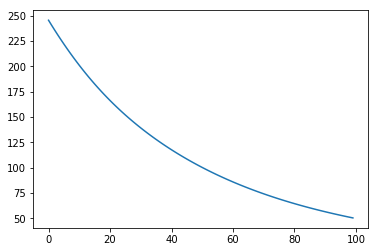

In [22]:
plt.plot(range(len(losses)), [float(x) for x in losses])